## scRNAseq CD8 Tm high salt and low salt preprocessing and analysis

Author: Maha Alissa Alkhalaf

Figures: Figure 3 (B-D), Figure 4 (K, M), Figure S10 (B-K)

In [1]:
import scanpy as sc
import scrublet as scr
import numpy as np
import gseapy as gp
import pandas as pd
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt
import scipy.stats as stats
import celltypist
from pathlib import Path
import os
import re
from statannot import add_stat_annotation

## Preprocessing

In [2]:
low_salt = sc.read_h5ad('../data/salt_data/low_salt.h5ad')
high_salt = sc.read_h5ad('../data/salt_data/high_salt.h5ad')

In [3]:
low_salt

AnnData object with n_obs × n_vars = 5976 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT'
    var: 'features'

In [4]:
high_salt

AnnData object with n_obs × n_vars = 4367 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT'
    var: 'features'

In [5]:
low_salt.obs['Condition'] = 'low salt'
high_salt.obs['Condition'] = 'high salt'

In [6]:
scrub = scr.Scrublet(high_salt.raw.X)
high_salt.obs['doublet_scores'], high_salt.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.9%
Elapsed time: 5.2 seconds


In [7]:
scrub = scr.Scrublet(low_salt.raw.X)
low_salt.obs['doublet_scores'], low_salt.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 42.9%
Elapsed time: 5.6 seconds


In [8]:
low_salt = low_salt[low_salt.obs['predicted_doublets'] == False, :]
high_salt = high_salt[high_salt.obs['predicted_doublets'] == False, :]

In [9]:
adata = sc.concat([low_salt, high_salt], label = 'dataset')
adata

AnnData object with n_obs × n_vars = 10335 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Condition', 'doublet_scores', 'predicted_doublets', 'dataset'

In [10]:
sc.pp.filter_cells(adata, min_genes = 200)

In [11]:
sc.pp.filter_genes(adata, min_cells = 3)
adata

AnnData object with n_obs × n_vars = 9835 × 25554
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Condition', 'doublet_scores', 'predicted_doublets', 'dataset', 'n_genes'
    var: 'n_cells'

In [12]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [13]:
sc.pp.scale(adata, max_value = 10)

In [14]:
adata.raw = adata

In [15]:
adata.X = np.nan_to_num(adata.X, nan = 0)

In [16]:
sc.pp.highly_variable_genes(adata)

In [17]:
sc.pp.pca(adata, n_comps = 30, use_highly_variable = True, svd_solver = 'arpack')

In [18]:
sc.pp.neighbors(adata, n_neighbors = 15)

In [19]:
sc.tl.umap(adata)

In [20]:
adata.write('../data/salt_data/high_and_low_salt.h5ad')

... storing 'Condition' as categorical


## Module Score

In [3]:
adata = sc.read_h5ad('../data/salt_data/high_and_low_salt.h5ad')

In [7]:
def gene_expression(adata, gene, conditions, condition):
    plt.figure(figsize = (2, 2.5), dpi = 300)

    gene_index = np.where(adata.var.index == gene)[0][0]
    high_salt = adata.X[[condition == conditions[0] for condition in adata.obs[condition]], gene_index]
    low_salt = adata.X[[condition == conditions[1] for condition in adata.obs[condition]], gene_index]
    
    alternatives = ['greater', 'less']
    p_values = []
    for alternative in alternatives:
        _ , p = stats.ranksums(high_salt, low_salt, alternative = alternative)
        p_values.append(p)
    p_values = [f'{i[0]} : {i[1]:.2e}' for i in list(zip(alternatives, p_values))]

    colors = ['#ffa37b', '#A7C7E7']
    customPalette = sns.set_palette(sns.color_palette(colors))

    ax = sns.violinplot(data = [high_salt, low_salt], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
    for i, c in enumerate(ax.collections):
        ax.collections[i].set_edgecolor('black')

    sns.boxplot(data = [high_salt, low_salt], width = 0.4,
                boxprops = {'zorder': 2, 'edgecolor' : 'black'},
                capprops = {'color' : 'black'},
                whiskerprops = {'color' : 'black'},
                medianprops = {'color' : 'black'},
                showfliers = False,
                linewidth = 0.3,
                ax = ax)

    sns.stripplot(data = [high_salt, low_salt], color = 'black', ax = ax, size = 0.4)

    ax.set_ylabel(f'Log-scaled expression value', fontsize = 4)

    ax.set_yticklabels(ax.get_yticks(), size = 4);
    ax.set_xticklabels(ax.get_xticklabels(), size = 4);

    labels = [item.get_text() for item in ax.get_yticklabels()]

    ax.set_xticklabels([conditions[0], conditions[1]])
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

    ax.set_title(f'Gene: {gene}\nWilcoxon rank sum, p-values:\n {", ".join(p_values)}', fontsize = 4)
    sns.despine()
    plt.savefig(f'../figures/violin_plot_expression_values_of_{gene}_in_{conditions}_cd8_azizi.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.clf()

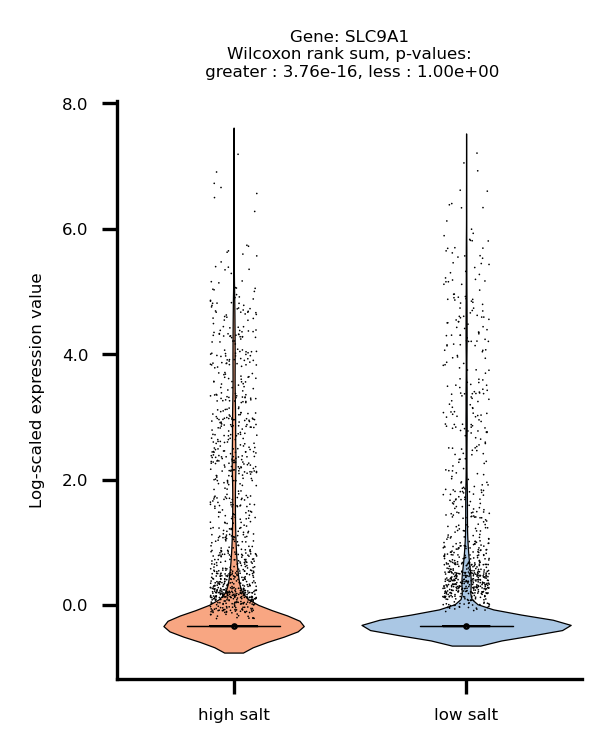

<Figure size 640x480 with 0 Axes>

In [6]:
gene_expression(adata, 'SLC9A1', ['high salt', 'low salt']) 

In [2]:
adata_azizi = sc.read_h5ad('../data/azizi_data/adata_azizi.h5ad')
adata_azizi

AnnData object with n_obs × n_vars = 254 × 24705
    obs: 'Patient ID', 'Tissue', 'Tumor', 'Normal', 'dataset', 'Condition', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'Cell Type', 'score'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [2]:
single_cell = pd.read_csv('../data/CD8T_salt/new_single_cell/DEG_high_vs_low_salt_Mahima', sep = '\t')
single_cell.sort_values('avg_log2FC', inplace = True, ascending = False) 

single_cell_upregulated_sig = list(single_cell.query('(avg_log2FC > 0) and (p_val_adj < 0.001)')['Unnamed: 0'])
single_cell_downregulated_sig = list(single_cell.query('(avg_log2FC < 0) and (p_val_adj < 0.001)')['Unnamed: 0'])


gene_set_significant = {
                       'single_cell_upregulated'   : single_cell_upregulated_sig,
                       'single_cell_downregulated' : single_cell_downregulated_sig
                       }

sc_salt_group
cd8+_high_salt    215
cd8+_low_salt      39
Name: count, dtype: int64


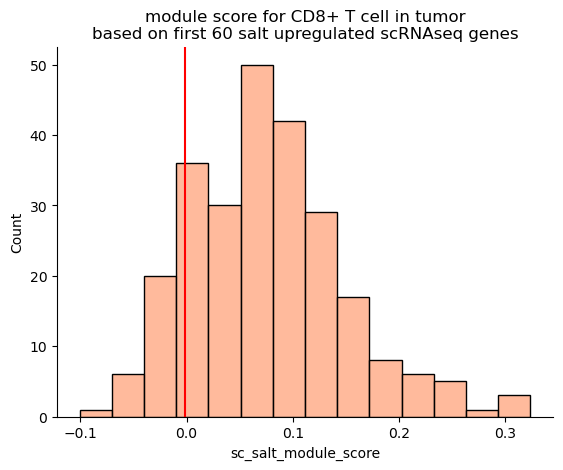

In [54]:
sc.tl.score_genes(adata_azizi, gene_list=gene_set_significant['single_cell_upregulated'][:100], score_name='sc_salt_module_score')

threshold = -0.001

# Create a new column indicating high or low salt based on the threshold
adata_azizi.obs['sc_salt_group'] = pd.cut(adata_azizi.obs['sc_salt_module_score'], bins=[-float('inf'), threshold, float('inf')],
                                 labels=['cd8+_low_salt', 'cd8+_high_salt'], include_lowest=True)

print(adata_azizi.obs['sc_salt_group'].value_counts())
sns.histplot(adata_azizi.obs['sc_salt_module_score'])
plt.title('module score for CD8+ T cell in tumor\nbased on first 60 salt upregulated scRNAseq genes')
plt.axvline(x = threshold, color = 'red', label = 'cut-off for high_salt CD8+ T cells')

sns.despine()

plt.savefig(f'../figures/module score for CD8+ T cell in tumor\nbased on first 60 salt upregulated scRNAseq genes.pdf', dpi = 300, bbox_inches = 'tight')

In [55]:
adata_azizi.obs['salt_top_60'] = 'low salt CD8+ azizi'
adata_azizi.obs.loc[adata_azizi.obs.iloc[np.where(adata_azizi.obs['sc_salt_module_score'] >= 0.075)[0], :].index, 'salt_top_60'] = 'high salt CD8+ azizi'

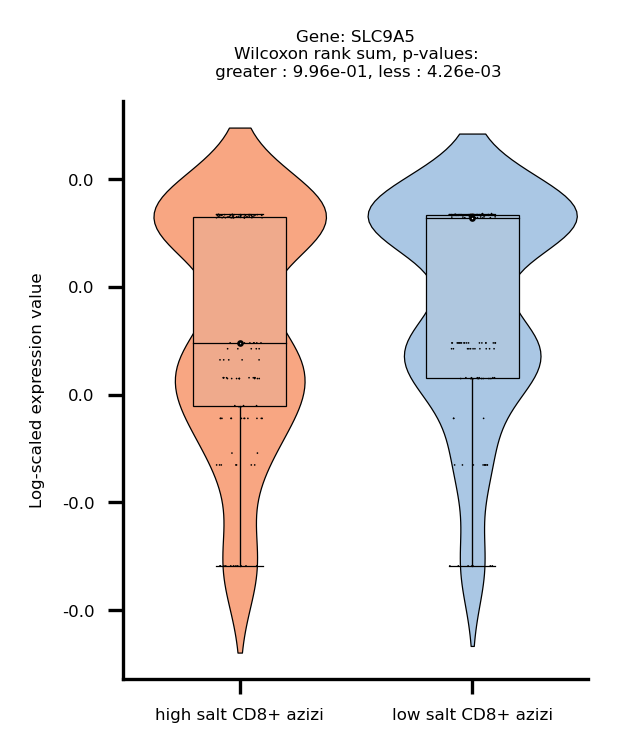

<Figure size 640x480 with 0 Axes>

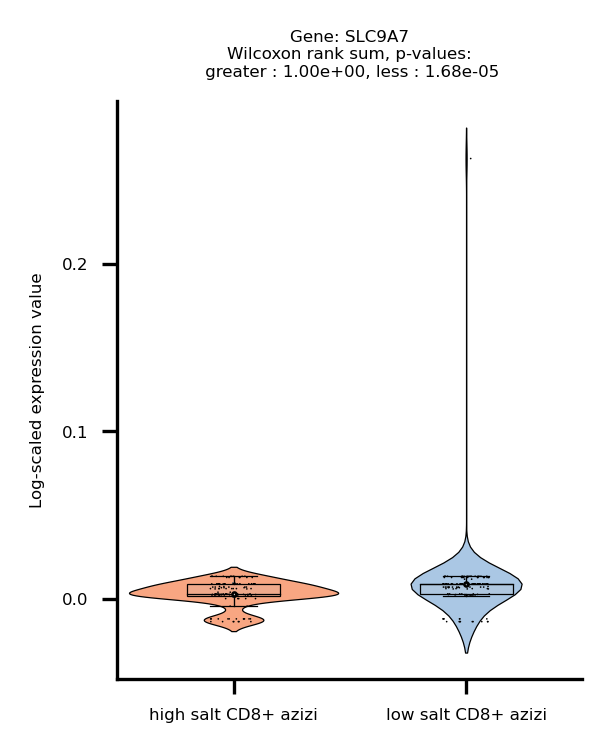

<Figure size 640x480 with 0 Axes>

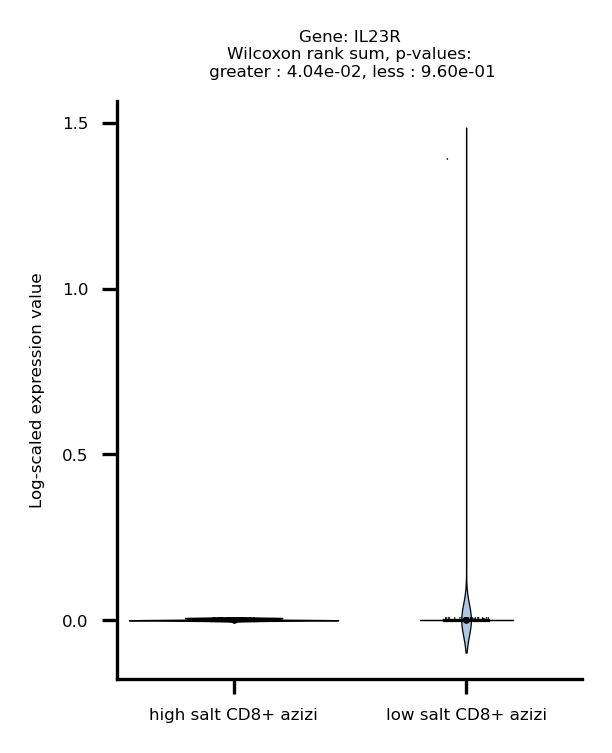

<Figure size 640x480 with 0 Axes>

In [56]:
gene_expression(adata_azizi, 'SLC9A5', ['high salt CD8+ azizi', 'low salt CD8+ azizi'], 'salt_top_60') 
gene_expression(adata_azizi, 'SLC9A7', ['high salt CD8+ azizi', 'low salt CD8+ azizi'], 'salt_top_60') 
gene_expression(adata_azizi, 'IL23R', ['high salt CD8+ azizi', 'low salt CD8+ azizi'], 'salt_top_60') 

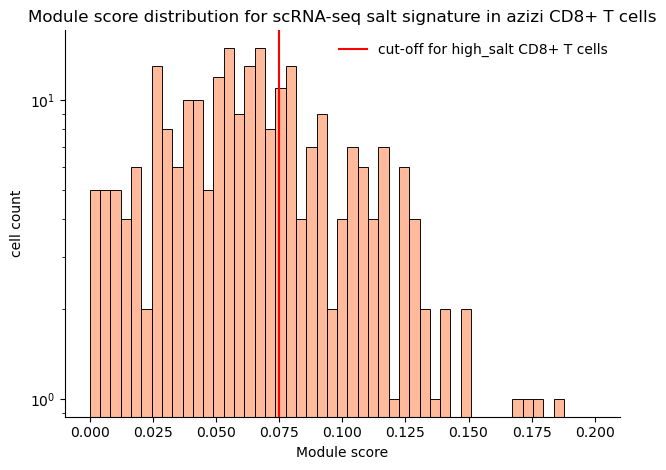

In [19]:
sns.histplot(adata_azizi.obs['score'], bins=np.linspace(0, .2, 50))


plt.title('Module score distribution for scRNA-seq salt signature in azizi CD8+ T cells')

plt.axvline(x = 0.075, color = 'red', label = 'cut-off for high_salt CD8+ T cells')
plt.xlabel('Module score')
plt.yscale('log')
plt.ylabel('cell count')
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

plt.savefig(f'../figures/histogram_module_score_salt_signature_azizi.pdf', dpi = 300, bbox_inches = 'tight')

In [ ]:
sc.pl.umap(adata_azizi, color='')

In [20]:
adata_azizi.obs['salt'] = 'low salt CD8+ azizi'

In [25]:
adata_azizi.obs.loc[adata_azizi.obs.iloc[np.where(adata_azizi.obs['score'] >= 0.075)[0], :].index, 'salt'] = 'high salt CD8+ azizi'

In [26]:
adata_azizi.obs['salt'].value_counts()

salt
low salt CD8+ azizi     156
high salt CD8+ azizi     98
Name: count, dtype: int64

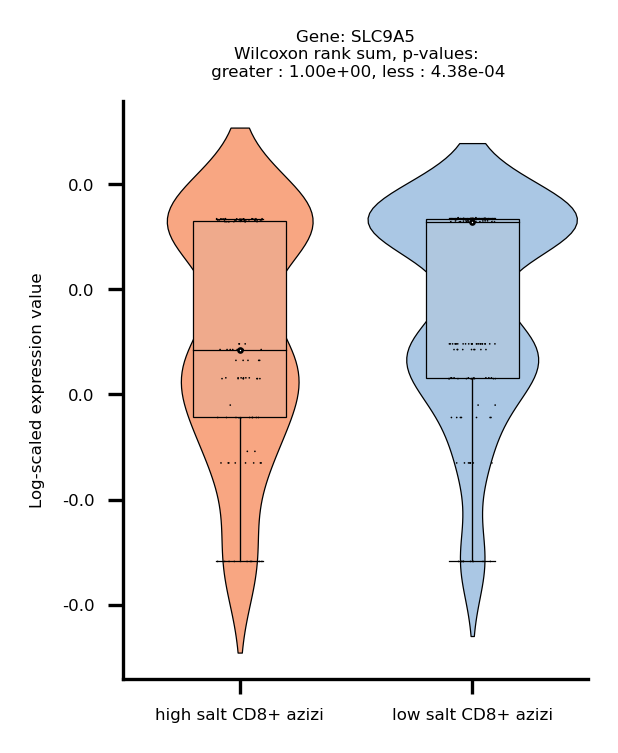

<Figure size 640x480 with 0 Axes>

In [27]:
gene_expression(adata_azizi, 'SLC9A5', ['high salt CD8+ azizi', 'low salt CD8+ azizi'], 'salt') 

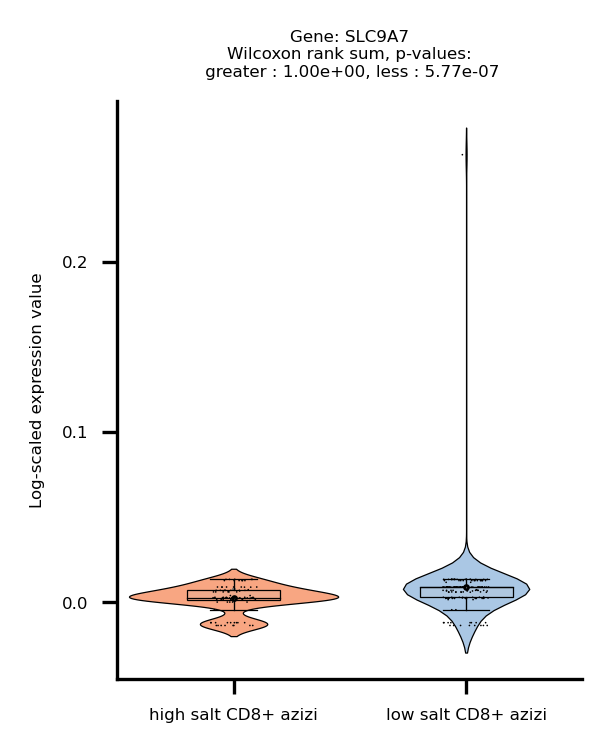

<Figure size 640x480 with 0 Axes>

In [28]:
gene_expression(adata_azizi, 'SLC9A7', ['high salt CD8+ azizi', 'low salt CD8+ azizi'], 'salt') 

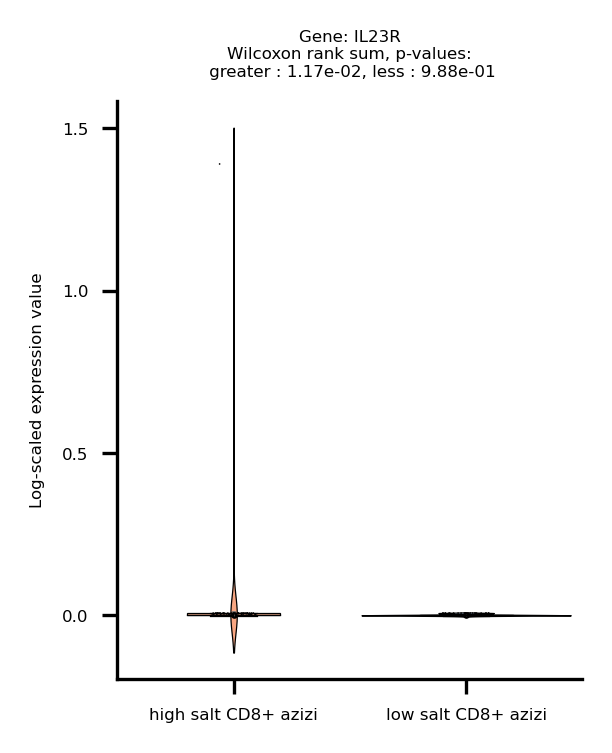

<Figure size 640x480 with 0 Axes>

In [29]:
gene_expression(adata_azizi, 'IL23R', ['high salt CD8+ azizi', 'low salt CD8+ azizi'], 'salt') 

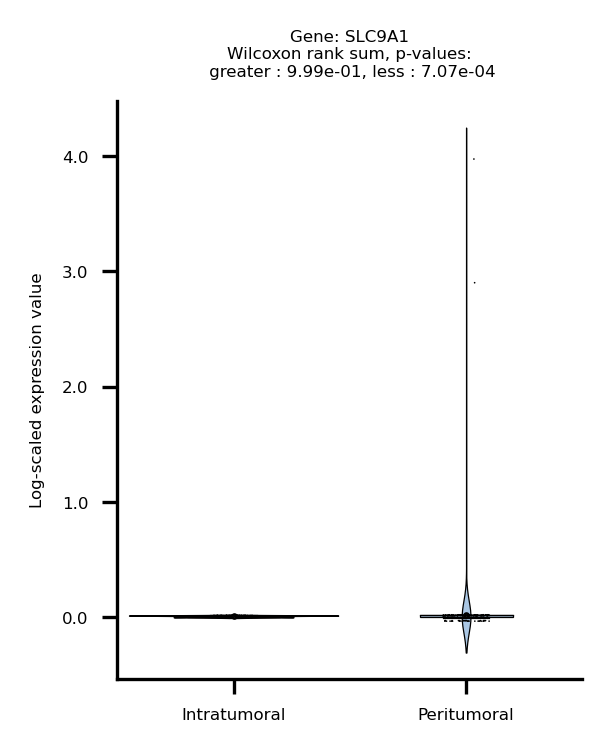

<Figure size 640x480 with 0 Axes>

In [25]:
adata_azizi.obs['Condition'] = adata_azizi.obs['Condition'].replace({'Tumor' : 'Intratumoral', 'Normal' : 'Peritumoral'})
gene_expression(adata_azizi, 'SLC9A1', ['Intratumoral', 'Peritumoral'], 'Condition') 

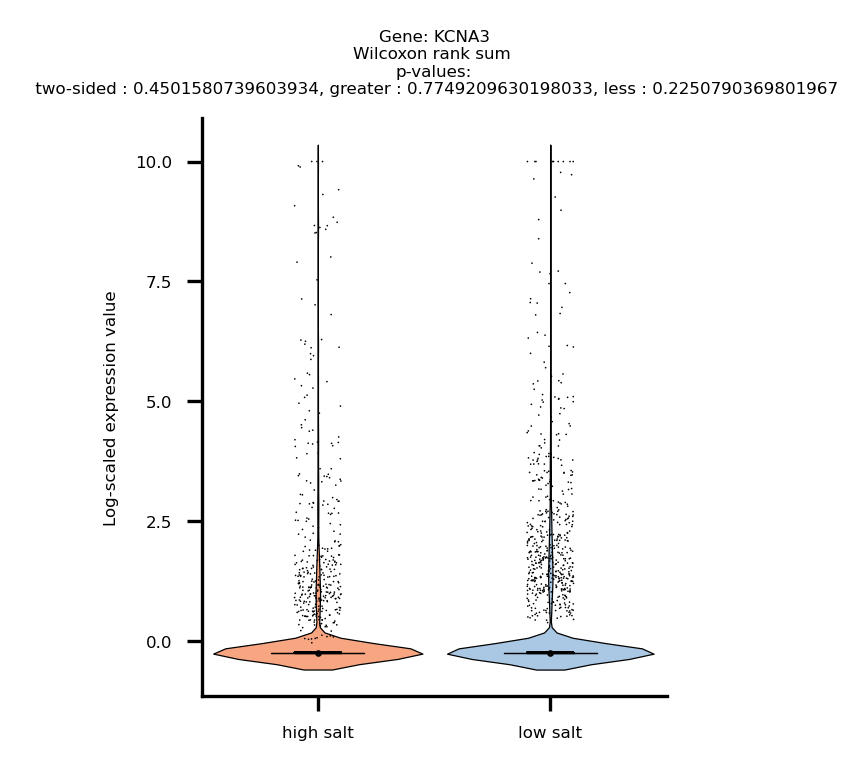

<Figure size 640x480 with 0 Axes>

In [63]:
# The Kv1.3 potassium channel is a voltage-activated channel that plays a central role in the activation of T cells. When T cells are activated, calcium ions enter the cell, depolarizing the cell membrane. This depolarization activates Kv1.3 channels, allowing K+ to exit the cell, which in turn repolarizes the cell membrane.
# https://www.nature.com/articles/s41467-022-31285-5
gene_expression(adata, 'KCNA3', ['high salt', 'low salt']) 

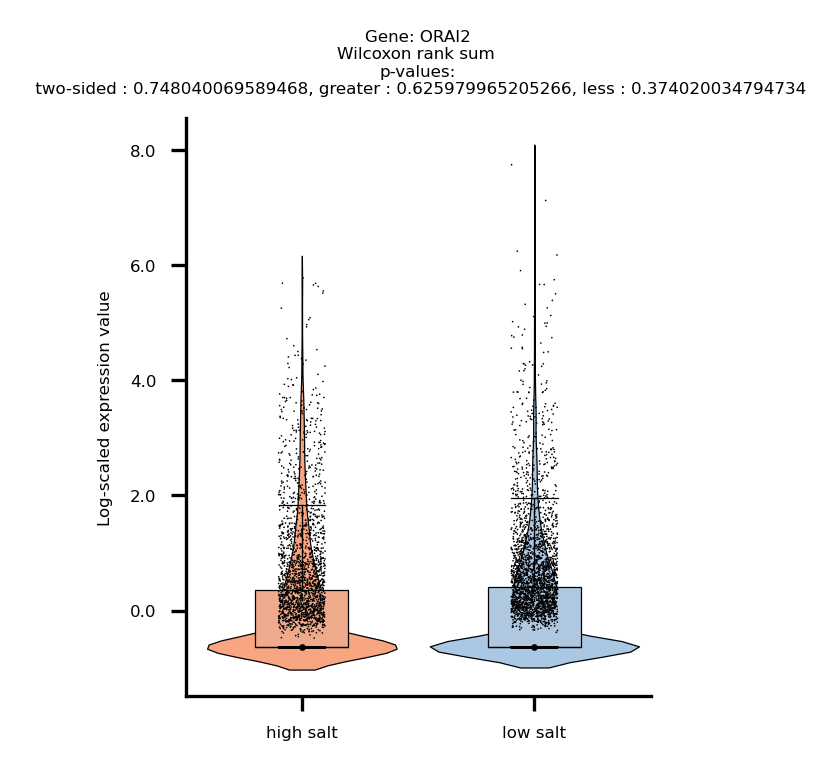

<Figure size 640x480 with 0 Axes>

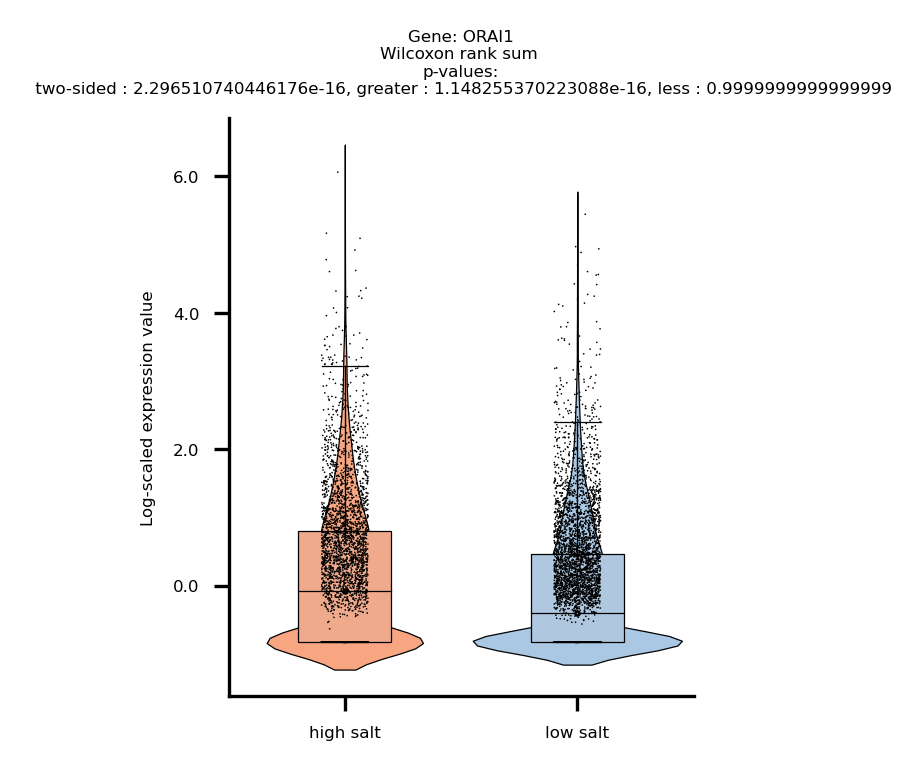

<Figure size 640x480 with 0 Axes>

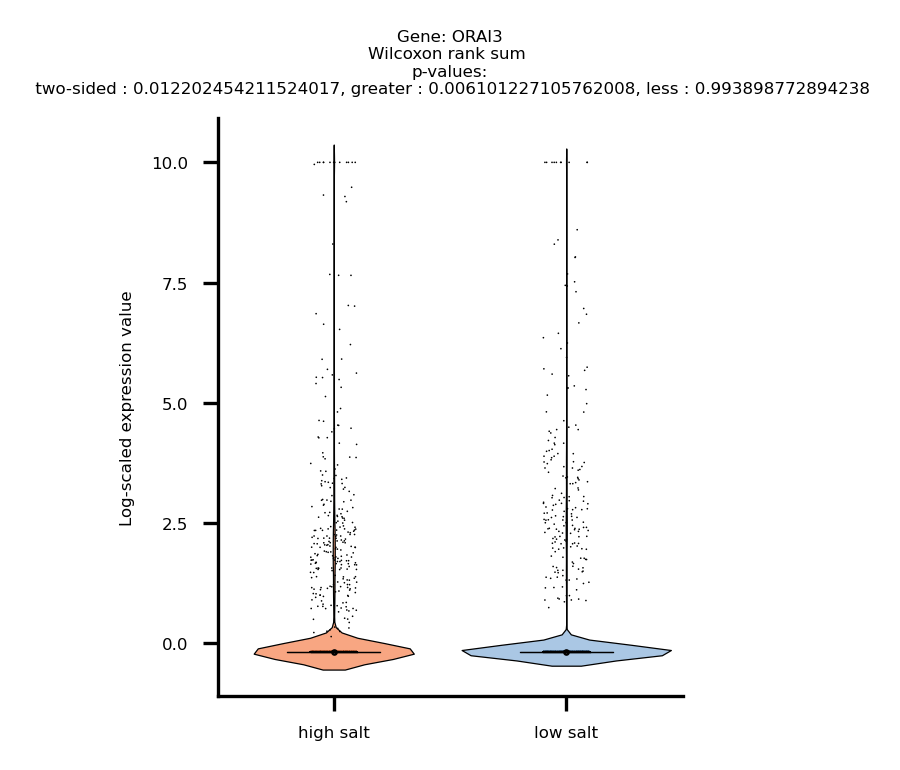

<Figure size 640x480 with 0 Axes>

In [64]:
# ORAI channels: primary channels responsible for Ca2+ influx during T cell activation
# https://www.nature.com/articles/s41577-018-0110-7#:~:text=Fig,players%20in%20T%20cell%20activation
for gene in [gene for gene in adata.var_names if gene.startswith('ORAI')]:
    gene_expression(adata, gene, ['high salt', 'low salt']) 

In [ ]:
gene_expression(adata, 'SLC5A1', ['high salt', 'low salt']) 

In [65]:
for gene in [gene for gene in adata.var.index if gene.startswith('SLC8')]:
    gene_expression(adata, gene, ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 600x750 with 0 Axes>

In [4]:
gene_expression(adata, 'ICOS', ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

In [8]:
gene_expression(adata, 'ITGAE', ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

In [7]:
gene_expression(adata, 'PDCD1', ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

In [246]:
gene_expression(adata, 'XYLT1', ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

In [4]:
gene_expression(adata, 'SLC7A5', ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

In [247]:
gene_expression(adata, 'FABP5', ['high salt', 'low salt']) 

<Figure size 600x750 with 0 Axes>

In [3]:
marker_genes_tissue_residency = {}
column_names = []
for i in range(36):
    df = pd.read_excel('../data/salt_data/TRM_Signatures.xlsx', i)
    column_name = df.columns[0]
    column_names.append(column_name)
    marker_genes_tissue_residency[column_name] = list(df[column_name])[1:]

In [46]:
def module_score(adata, data_set, data_set_name):

    sc.tl.score_genes(adata, data_set)

    low_salt_module = np.array(adata.obs[adata.obs.Condition == 'low salt']['score'])
    high_salt_module = np.array(adata.obs[adata.obs.Condition == 'high salt']['score'])

    plt.figure(figsize = (2, 2.5), dpi = 300)
    alternative = 'greater'

    
    '''
    # UNCOMMENT THE FOLLOWING CONDITIONS WHEN RUNNING THIS FUNCTION FOR THE Trm & Cir genesets
    if 'trm'== data_set_name.split('_')[1]:
        alternative = 'greater'
    elif 'cir' == data_set_name.split('_')[1]:
        alternative = 'less'
    '''
    

    alternatives = ['greater', 'less']
    p_values = []
    for alternative in alternatives:
        _ , p = stats.ranksums(high_salt_module, low_salt_module, alternative = alternative)
        p_values.append(p)
    p_values = [f'{i[0]} : {i[1]:.2e}' for i in list(zip(alternatives, p_values))]

    colors = ['#ffa37b', '#A7C7E7']
    customPalette = sns.set_palette(sns.color_palette(colors))

    ax = sns.violinplot(data = [high_salt_module, low_salt_module], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
    for i, c in enumerate(ax.collections):
        ax.collections[i].set_edgecolor('black')

    sns.boxplot(data = [high_salt_module, low_salt_module], width = 0.4,
                boxprops = {'zorder': 2, 'edgecolor' : 'black'},
                capprops = {'color' : 'black'},
                whiskerprops = {'color' : 'black'},
                medianprops = {'color' : 'black'},
                showfliers = False,
                linewidth = 0.3,
                ax = ax)

    sns.stripplot(data = [high_salt_module, low_salt_module], color = 'black', ax = ax, size = 0.4)

    ax.set_ylabel(f'Module score', fontsize = 4)

    ax.set_yticklabels(ax.get_yticks(), size = 4);
    ax.set_xticklabels(ax.get_xticklabels(), size = 4);

    labels = [item.get_text() for item in ax.get_yticklabels()]

    ax.set_xticklabels(['High salt', 'Low salt'])
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

    ax.set_title(f'{data_set_name}\nWilcoxon rank sum, p-values:\n {", ".join(p_values)}', fontsize=4)
    sns.despine()
    
    plt.savefig(f'../figures/violin_plot_module_score_of_{data_set_name}_genes_in_high_vs_low_salt.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.clf()

    #sc.pl.umap(adata, color = ['score'], title = f'Module score of {data_set_name}', show = False, color_map = 'Reds')
    #plt.savefig(f'../figures/umap_module_score_of_{data_set_name}_genes_in_high_vs_low_salt.pdf', dpi = 300, bbox_inches = 'tight')
    #plt.clf()

In [4]:
eff1 = pd.read_csv('../data/salt_data/Effector_gene_set_Table_S3.csv', sep = ';')
eff1

,"Table S3: Gene set used for Figure 1C, effector gene GSEA.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,d6ARM_vs_N,NaN,NaN,NaN,NaN
2,PSAT1,NaN,NaN,NaN,NaN
3,IL18RAP,NaN,NaN,NaN,NaN
4,41161,NaN,NaN,NaN,NaN
...,...,...,...,...,...
166,PRF1,NaN,NaN,NaN,NaN
167,HIST1H3C,NaN,NaN,NaN,NaN
168,CHTF18,NaN,NaN,NaN,NaN
169,NRM,NaN,NaN,NaN,NaN


In [31]:
module_score(adata, eff1['Table S3: Gene set used for Figure 1C, effector gene GSEA. '], 'Table S3: Gene set used for Figure 1C, effector gene GSEA (1. excel sheet)')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
eff2 = pd.read_csv('../data/salt_data/NIHMS866030-supplement-Table_S3.csv', sep = ';')
eff2

,"Table S3: Gene set used for Figure 1C, effector gene GSEA.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NAME,PROBE,RANK IN GENE LIST,RANK METRIC SCORE,RUNNING ES,CORE ENRICHMENT
2,row_0,RBM47,7,"0,303581476211547","0,036805205",Yes
3,row_1,EPAS1,30,"0,248808145523071","0,06596747",Yes
4,row_2,H1F0,68,"0,201966762542724","0,08845972",Yes
...,...,...,...,...,...,...
162,row_160,ANXA1,15058,"-0,104947358369827","0,019064121",No
163,row_161,GINS1,15213,"-0,110784135758876","0,02316056",No
164,row_162,IL12RB2,15269,"-0,113381095230579","0,033677608",No
165,row_163,ITIH5,15485,"-0,124636098742485","0,035713237",No


In [32]:
module_score(adata, eff2['Unnamed: 1'], 'Table S3: Gene set used for Figure 1C, effector gene GSEA (2. excel sheet)')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
cyto1 = pd.read_csv('../data/salt_data/cyto_list1.csv')
cyto1

,genes
0,HLA-C
1,CD1D
2,CD1E
3,SLC22A13
4,HLA-F
5,MR1
6,P2RX7
7,CD1A
8,ULBP3
9,XCL1


In [6]:
module_score(adata, cyto1['genes'], 'Cyto_list1 GO:0001916')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
cyto2 = pd.read_csv('../data/salt_data/cyto_list2.csv')
cyto2

,genes
0,GZMA
1,GZMB
2,GNLY
3,PRF1
4,IFNG


In [36]:
module_score(adata, cyto2['genes'], 'Cyto_list2')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [37]:
cyto3 = pd.read_csv('../data/salt_data/cyto_list3.csv')
cyto3

,genes
0,CTSW
1,GNLY
2,GZMA
3,GZMB
4,GZMH
5,IFNG
6,KLRB1
7,KLRD1
8,KLRK1
9,NKG7


In [38]:
module_score(adata, cyto3['genes'], 'Cyto_list3')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
tissure_residency_gustavo = ['XIST', 'UBC', 'LGALS3', 'MT-CO2', 'VIM', 'ANKRD28', 'RGS1', 'RGCC', 'HSPA1B', 'MT-ND4', 'HSP90Ab1', 'PPP1R15A']

In [6]:
module_score(adata, tissure_residency_gustavo, 'Tissue residency markers in host vs. donor CD8+ T cells')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
for column_name in column_names:
    data_set = marker_genes_tissue_residency[column_name]
    print(column_name)
    module_score(adata, data_set, column_name)

#goldrath_cir_signature_genes
1.0
#goldrath_trm_signature_genes
0.0
#gratz_cir_signature_genes_CD103+CCR7-_skin_vs_CD103+CCR7-_blood_lfc<-2_padj<0.05
0.8745756373355293
#gratz_trm_signature_genes_CD103+CCR7-_skin_vs_CD103-CCR7-_blood_lfc>2_padj<0.05
0.0
#gratz_cir_signature_genes_CD103+CCR7-_skin_vs_CD103+CCR7-_blood_lfc<-2_padj<0.05
0.8745756373355293
#gratz_trm_signature_genes_CD103+CCR7-_skin_vs_CD103+CCR7-_blood_lfc>2_padj<0.05
0.0
#gratz_cir_signature_genes_CD103+CCR7-_skin_vs_CD103-CCR7-_skin_lfc<-2_padj<0.05
1.0
#gratz_trm_signature_genes_CD103+CCR7-_skin_vs_CD103-CCR7-_skin_lfc>2_padj<0.05
0.40909975081064387
#gratz_cir_signature_genes_CD103+CCR7-_blood_vs_CD103-CCR7-_blood_lfc<-2_padj<0.05
1.0
#gratz_trm_signature_genes_CD103+CCR7-_blood_vs_CD103-CCR7-_blood_lfc>2_padj<0.05
8.572504257912831e-08
#mackay_cir_signature_genes_skin_CD103+_trm_vs_spleen_tcm_lfc<0_padj<0.05
0.9909194455784361
#mackay_trm_signature_genes_skin_CD103+_trm_vs_spleen_tcm_lfc>0_padj<0.05
9.051891705727707

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## GO Pathways

### mTOR KEGG

In [48]:
mtor_df = pd.read_csv('mtor_pathway_kegg.csv', sep=';')
mtor_df

,gene,info
0,WNT2,"wingless-type MMTV integration site family, me..."
1,WNT3,"wingless-type MMTV integration site family, me..."
2,WNT4,"wingless-type MMTV integration site family, me..."
3,WNT5,"wingless-type MMTV integration site family, me..."
4,WNT6,"wingless-type MMTV integration site family, me..."
...,...,...
112,"MAPKAP1, SIN1, AVO1",target of rapamycin complex 2 subunit MAPKAP1/...
113,"PRR5, PROTOR",proline-rich protein 5
114,ULK1,serine/threonine-protein kinase ULK1 [EC:2.7.1...
115,CASTOR1,cytosolic arginine sensor for mTORC1 subunit 1


In [49]:
mtor_genes_kegg = []

for gene in mtor_df['gene']:
    mtor_genes_kegg.extend(gene.split(', '))

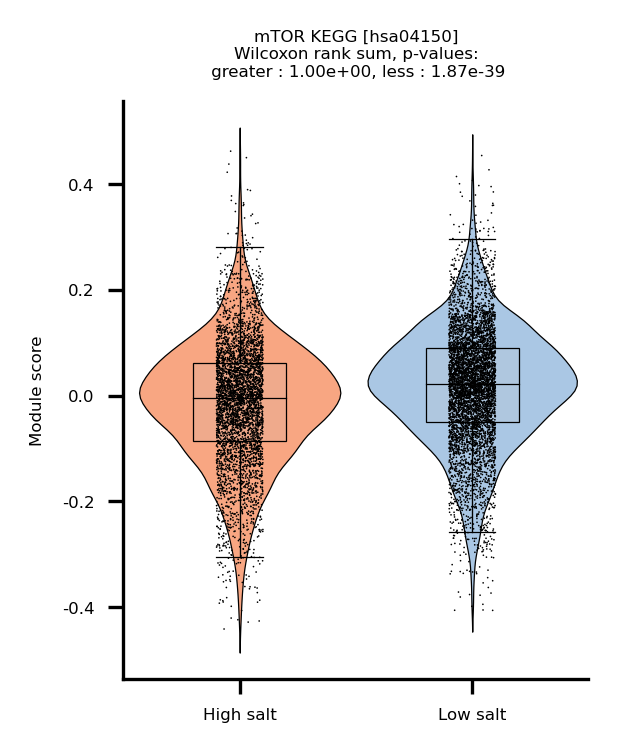

<Figure size 640x480 with 0 Axes>

In [51]:
module_score(adata, mtor_genes_kegg, 'mTOR KEGG [hsa04150]')

### mTOR complex

In [72]:
mtor_complexes = [gene for gene in adata.var_names if gene.startswith('MTOR')]
mtor_complexes

['MTOR', 'MTOR-AS1']

In [37]:
pathways = {}

In [28]:
pathways['GO-0006541'] = ['PFAS',
'GLYATL1B',
'CTPS2',
'GMPS',
'NIT2',
'CTPS1',
'GFPT1',
'PPAT',
'CAD',
'PHGDH',
'ASNSD1',
'GLS2',
'SIRT4',
'GLUD1',
'SLC38A1',
'ASL',
'GFPT2',
'ASNS',
'CPS1',
'ADSS1',
'MECP2',
'GLS',
'GLYATL1',
'UCP2',
'ARHGAP11B',
'GLUL',
'KCNE2',
'KCNH2',
'GINS',
'CSDE1',
'HBS1L',
'PELO',
'CNOT6',
'DRD4',
'DRD3',
'DRD2']

In [66]:
p1 = pd.read_csv('../data/go_pathways/GO-0005216.csv', header = None)
pathways['GO-0005216'] = list(p1[0]) #general monoatomic ion channel

In [67]:
p2 = pd.read_csv('../data/go_pathways/GO-0005262.csv')
pathways['GO-0005262'] = list(p2['Gene']) #calcium channel activity

In [68]:
path = Path('../data/go_pathways/')

for root, dirs, files in os.walk(path):
    for file in files:
        print(file)
        with open(f'{path}/{file}') as f:
            lines = f.readlines()
            genes = [line.replace('\n', '') for line in lines]
        pathway = file.replace('_', ', ').split('.')[0]
        pathways[pathway] = genes

Untitled.numbers


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xec in position 10: invalid continuation byte

GO-0005216, Number of genes: 477
0.001744792705837679


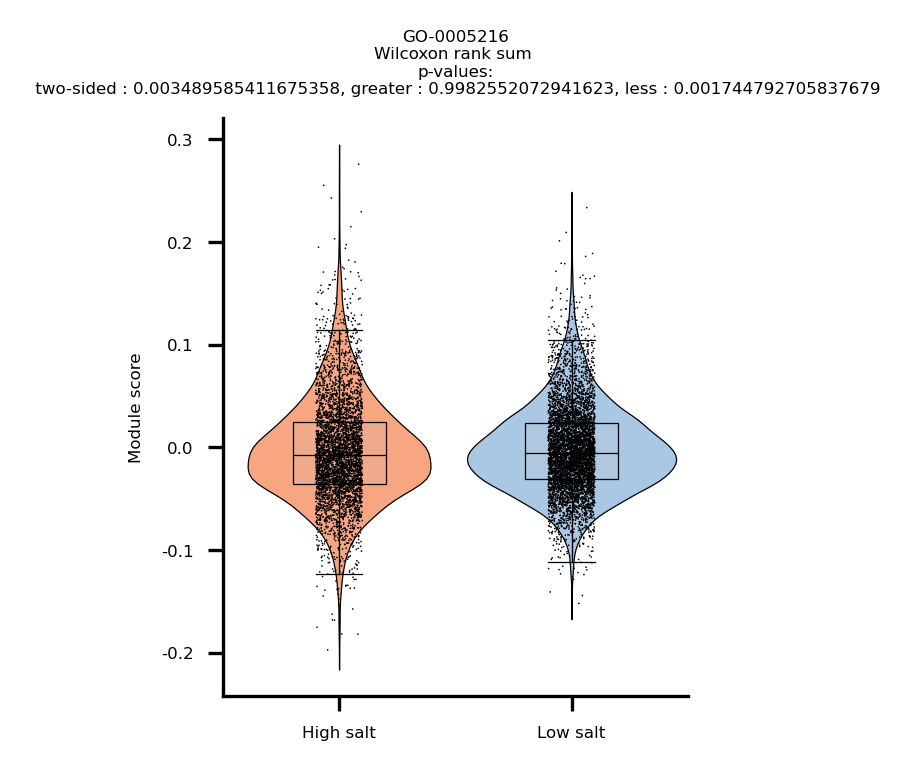

GO-0005262, Number of genes: 124
0.999998864459382


<Figure size 640x480 with 0 Axes>

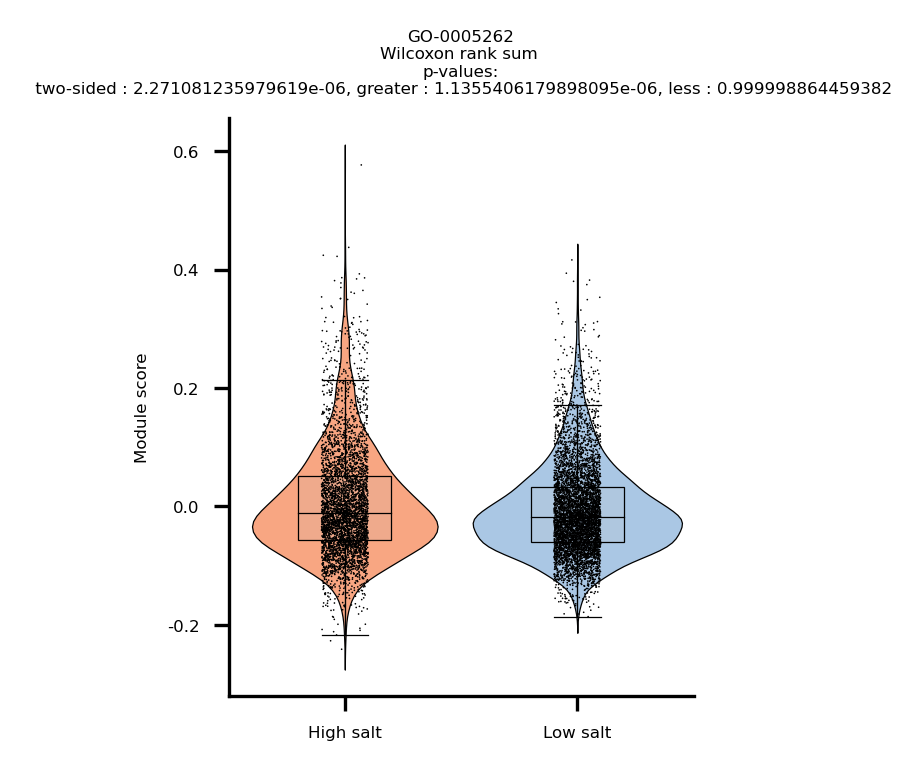

<Figure size 640x480 with 0 Axes>

In [69]:
for pathway in pathways:
    data_set = pathways[pathway]
    print(f'{pathway}, Number of genes: {len(data_set)}')
    module_score(adata, data_set, pathway)

In [14]:
hallmarks_glycolysis = pd.read_csv('../data/salt_data/HALLMARK_GLYCOLYSIS.tsv', sep = '\t')
hallmarks_glycolysis

,Genes,ABCB6,ADORA2B,AGL,AGRN,AK3,AK4,AKR1A1,ALDH7A1,ALDH9A1,...,TPI1,TPST1,GFUS,TXN,UGP2,VCAN,VEGFA,VLDLR,XYLT2,ZNF292


In [18]:
module_score(adata, list(hallmarks_glycolysis.columns), 'HALLMARK_GLYCOLYSIS')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
exhaustion_list1 = pd.read_csv('../data/salt_data/exhaustion_list1.csv')
exhaustion_list2 = pd.read_csv('../data/salt_data/exhaustion_list2.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/salt_data/exhaustion_list1.csv'

In [8]:
module_score(adata, list(exhaustion_list1['genes']), 'exhaustion_list1')
module_score(adata, list(exhaustion_list2['genes']), 'exhaustion_list2')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
eff_list1 = pd.read_csv('../data/salt_data/effector_list1.csv')
eff_list2 = pd.read_csv('../data/salt_data/effector_list2.csv')

In [15]:
module_score(adata, list(eff_list1['genes']), f'Effector list1 {list(eff_list1["genes"])}')
module_score(adata, list(eff_list2['genes']), f'Effector list2 {list(eff_list2["genes"])}')

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 600x750 with 0 Axes>

<Figure size 640x480 with 0 Axes>